In [0]:
import os
import cv2
import PIL
import copy
import time
import torch
import shutil
import random
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import datasets
import matplotlib.image as mpimg
from torchvision import transforms
from torch.optim import lr_scheduler
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine([-90,90]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


In [0]:
data_dir = "/content/drive/My Drive/path/images"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [109]:
image_datasets['val'].class_to_idx

{'Defective': 0, 'Good': 1}

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # if(phase == 'val'): 
                    #   print(labels)
                    #   print(outputs)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # print(labels)
            # print(outputs)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/My Drive/path/ATTEMPT_2.pth")
    return model

In [0]:
vgg19 = models.vgg19(pretrained=True)

for param in vgg19.parameters():
    param.requires_grad_(False)
vgg19.classifier = nn.Sequential(
                    nn.Linear(25088,4096,bias = True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(4096,2048,bias = True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(2048,2,bias = True)
                    )
vgg19  = vgg19.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer1 = optim.SGD(vgg19.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)

In [113]:
# vgg19.load_state_dict(torch.load("/content/drive/My Drive/path/model.pth"))
# vgg19.eval()
vgg19 = train_model(vgg19, criterion, optimizer1,
                          exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5810 Acc: 0.7033
val Loss: 0.5130 Acc: 0.7607

Epoch 1/24
----------
train Loss: 0.5105 Acc: 0.7637
val Loss: 0.4860 Acc: 0.7957

Epoch 2/24
----------
train Loss: 0.5011 Acc: 0.7734
val Loss: 0.4959 Acc: 0.7637

Epoch 3/24
----------
train Loss: 0.4841 Acc: 0.7785
val Loss: 0.5020 Acc: 0.7668

Epoch 4/24
----------
train Loss: 0.4706 Acc: 0.7840
val Loss: 0.5446 Acc: 0.7713

Epoch 5/24
----------
train Loss: 0.4566 Acc: 0.7942
val Loss: 0.4820 Acc: 0.7698

Epoch 6/24
----------
train Loss: 0.4611 Acc: 0.7881
val Loss: 0.5141 Acc: 0.7546

Epoch 7/24
----------
train Loss: 0.4381 Acc: 0.7962
val Loss: 0.5067 Acc: 0.7500

Epoch 8/24
----------
train Loss: 0.4242 Acc: 0.8049
val Loss: 0.5030 Acc: 0.7485

Epoch 9/24
----------
train Loss: 0.4256 Acc: 0.7973
val Loss: 0.4994 Acc: 0.7637

Epoch 10/24
----------
train Loss: 0.4185 Acc: 0.8059
val Loss: 0.5063 Acc: 0.7546

Epoch 11/24
----------
train Loss: 0.4111 Acc: 0.8100
val Loss: 0.4943 Acc: 0.7652

Ep

In [114]:
data_dir = "/content/drive/My Drive/path/data"
transform = transforms.Compose([transforms.Resize([300,300]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
real_dataset = datasets.ImageFolder(data_dir,transform)
dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=4,
                                          shuffle=True, num_workers=4)
dataset_size =  len(real_dataset)
class_names = real_dataset.classes
print(real_dataset.class_to_idx)
print("size:",dataset_size)

{'Defective': 0, 'Good': 1}
size: 1280


In [0]:
def test_accuracy(model, criterion):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    # print('test Loss: {:.4f} Acc: {:.4f}'.format(
    #       epoch_loss, epoch_acc))

    print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(epoch_acc))
    return

In [116]:
criterion = nn.CrossEntropyLoss()
test_accuracy(vgg19,criterion)


Testing complete in 0m 28s
Test Acc: 0.524219


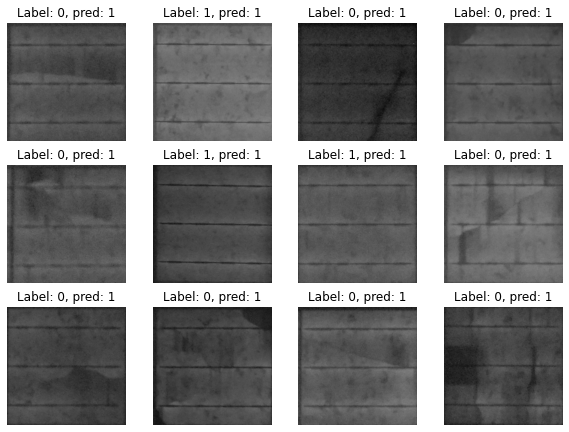

In [117]:
#converts normalised tensor input to presentable image 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


vgg19.eval()  #This would change the state if model is in trian mode
              #,to eval mode. remember to change it back to its original
              # state 
num_images=12 #multiple of $
images_so_far =0              
fig = plt.figure(figsize=(10,10))
with torch.no_grad():
  for i,(inputs, labels) in enumerate(dataloader,0):
  
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = vgg19(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size()[0]):
      images_so_far += 1
      ax = plt.subplot(num_images//4+1, 4, images_so_far)
      ax.axis('off')
      ax.set_title('Label: {}, pred: {}'.format(labels[j],preds[j]))
      imshow(inputs.cpu().data[j])
    if images_so_far >= num_images:
        break